In [1]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend
from tensorflow.keras import layers

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

from datetime import datetime

from tqdm.auto import tqdm

import IPython
from IPython import display
import ipywidgets as widgets

import ngraph_bridge
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.tools import freeze_graph
import json

from numpy.random import seed
from tensorflow import set_random_seed

def reset_seed():
    # Making results reproducible
    seed(10092)
    set_random_seed(10093)  

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

In [21]:
def showplots(f,approxlist,a,b, names=None):
    names = ["Original"] + ["Approx. %d" % (i) for i in range(len(approxlist))] if names is None else names
    
    figsize = (10, 8)
    figsize = (10, 10)
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=figsize)
    plt.subplot(211)
    
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label=names[i + 1])
    plt.plot(x,f(x), label=names[0])
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.subplot(212)
    for i, vf in enumerate(vfuncs):
        plt.plot(x,f(x)-vf(x), label=names[i + 1] + " Error")
    plt.xlim(a,b)
    plt.ylabel('error = f(x)-fa(x)')
    plt.xlabel('x')
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()


def showplot(f, approxlist, a, b, names=None):
    names = ["Original"] + ["Approx. %d" % (i) for i in range(len(approxlist))] if names is None else names
    figsize = (10, 5)
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=figsize)
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label=names[i + 1])
    plt.plot(x,f(x), label=names[0])
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()
    
def plot_vs(x, ys, errors, title):
    fig=plt.figure(figsize=(10, 8))
    Y = ys[0]
    for y in ys:
        plt.plot(X, y[0], label=y[1])

    for y in ys[1:]:
        plt.plot(X, np.abs(Y[0] - y[0]), label='Error %s vs %s' % (Y[1], y[1]), color='crimson')
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()

In [3]:
class ChebyshevPolynomial(object):
    def __init__(self, name='ChebyshevPolynomial'):
        self.__name__ = name
    
    def to_x(self, u, a, b):
        return ((b - a)/2) * u + ((a + b)/2)

    def to_u(self,x, a, b):
        return np.array((2 * x - a - b) / (b - a))
    
    def chebyshev_t(self, x, degree):
        if degree == 0:
            return np.ones(x.shape)
        elif degree == 1:
            return x
        else:
            return 2 * x * self.chebyshev_t(x, degree-1) - self.chebyshev_t(x, degree - 2)
        
    def chebyshev_nodes(self, N):
        t = (np.array(range(0, N)) + 0.5) / N
        return -np.cos(t * np.math.pi)
    
    def chebyshev_a(self, k):
        return 1 if k == 0 else 2
    
    def calculate_c(self, y, u, n, N):
        return self.chebyshev_a(n) * (y.dot(self.chebyshev_t(u, n))) / N

    def chebyshev_c(self, f, N, a, b):
        c = []
        u = self.chebyshev_nodes(N)
        x = self.to_x(u, a, b)
        y = f(x)
        for i in range(N):
            c.append(self.calculate_c(y, u, i, N))
        return np.round(c, 4)

    def fit(self, f, N, a, b):
        self.a = a
        self.b = b
        self.N = N
        self.C = self.chebyshev_c(f, N, a, b)
        return self 
    
    def predict_single(self, x):
        np.array((2 * x - self.a - self.b) / (self.b - self.a))
    def __call__(self, x):
        return self.predict(x)
    
    def as_function(self):
        if self.C is None:
            raise Exception
        def f(x):
            return self.predict(x)
        f = lambda x: self.predict(x)
        
        return f
    
    def __repr__(self):
        return "Cheby%s" % ((self.a, self.b)+tuple(c for c in self.C)).__repr__()
    
    def __str__(self):
        return r"$$f(x) =" + " ".join(["%+0.2f * T_%d(u)"%(c, i) for i, c in enumerate(self.C)]) + "$$"
        
    
    def eq(self):
        from IPython.display import display, Math, Latex
        display(Math(self.__str__()))
        
    def predict(self, x):
        # if self.C is None:http://127.0.0.1:10093/notebooks/mnt_dir/models/quickdraw/discriminator/AppleDiscriminator.ipynb#
        #    raise Exception
        
        u = self.to_u(x, self.a, self.b)
        y = np.zeros(u.shape)
        for degree, c in enumerate(self.C):
            ch = self.chebyshev_t(u, degree)
            y += c * ch
        
        return y

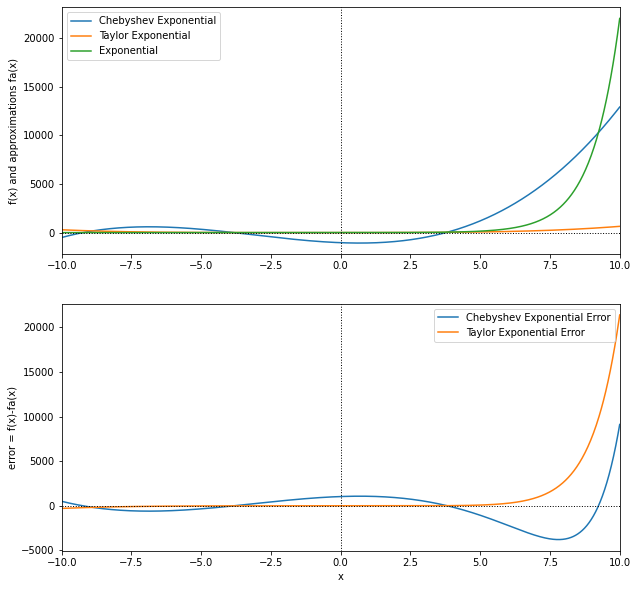

In [4]:
def taylor_exp(x, n=5):
    result = 1
    for i in range(1, n):
        result += ((x ** i) / (np.math.factorial(i)))
    return result 

def exp(x):
    e = 2.718281828459045
    return e ** x

r = 10
chebyshev_exp = ChebyshevPolynomial('chebyshev_exp').fit(np.exp, 4, -r, r)
showplots(np.exp, [chebyshev_exp, taylor_exp], -r,  r , 
          names=['Exponential', 'Chebyshev Exponential', 'Taylor Exponential'])

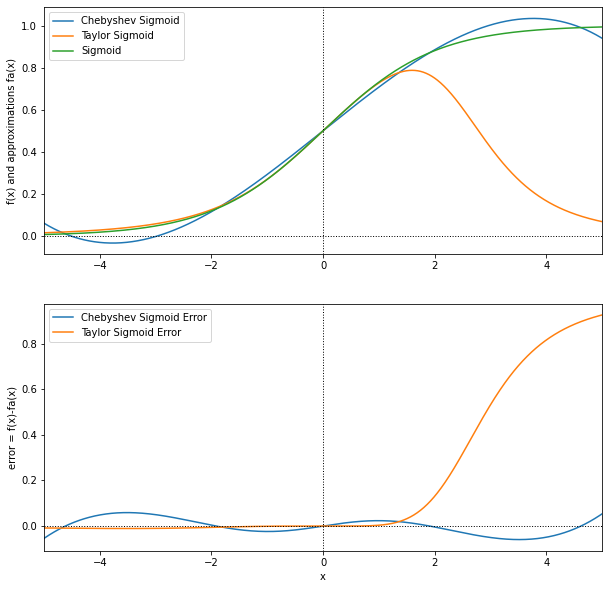

In [5]:
def taylor_sigmoid(x, n=5):
    return 1 / (1 + taylor_exp(-x, n))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalize_in_range(x, range_start, range_end, new_range_start= -1, new_range_end=1):
    zero_to_one = ((x - range_start) / (range_end - range_start))
    start_to_end = zero_to_one * (new_range_end - new_range_start) + new_range_start
    return start_to_end

def denormalize_in_range(x, range_start, range_end, new_range_start = -1, new_range_end=1):
    zero_to_one = ((x - new_range_start) / (new_range_end - new_range_start))
    start_to_end = zero_to_one * (range_end - range_start) + range_start
    return start_to_end
def taylor_sigmoid_norm(x, n=5, r=5):
    x = normalize_in_range(x, -r, r)
    return denormalize_in_range(taylor_sigmoid(x, n), -r, r)

r = 5
chebyshev_sigmoid = ChebyshevPolynomial('chebyshev_sigmoid').fit(sigmoid, 4, -r, r)
showplots(sigmoid, [chebyshev_sigmoid, taylor_sigmoid], -r ,  r, 
          names=['Sigmoid', 'Chebyshev Sigmoid', 'Taylor Sigmoid'])


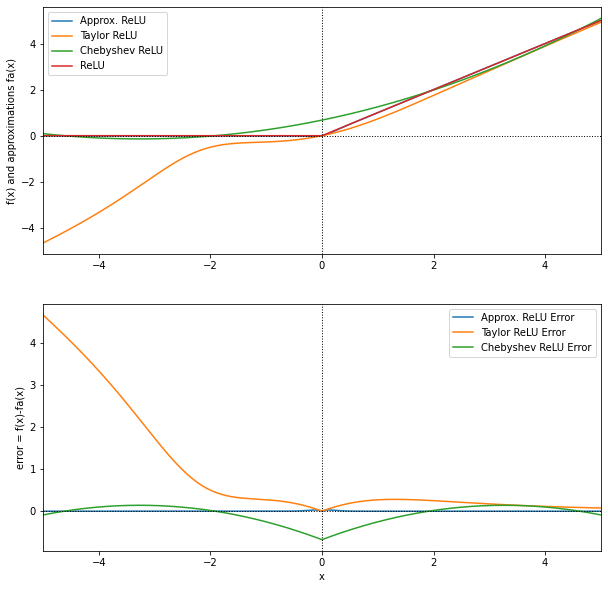

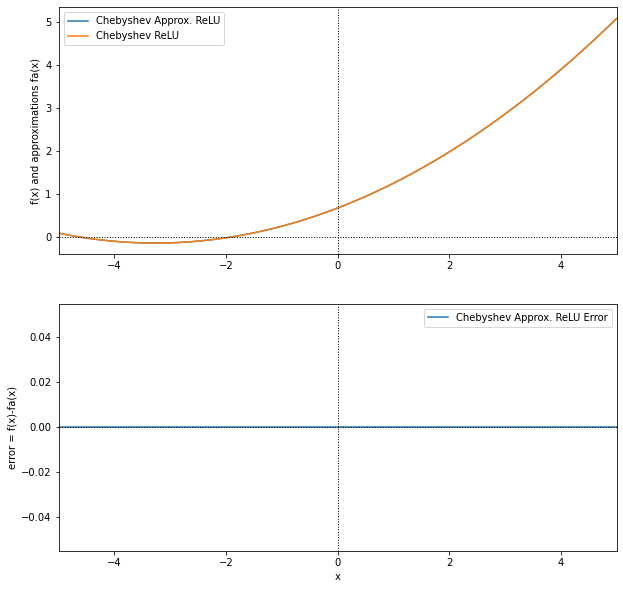

In [6]:
# Base relu implementation
def relu(x):
    return np.maximum(0, x)

# This approximation of the max function works as intended.
def approxmax(x, y, k=10):
    ekx = np.exp(k * x)
    eky = np.exp(k * y)
    return (x * ekx + y * eky) / (ekx + eky)

def approx_relu(x):
    return approxmax(x, 0)

# This is the same approximation using the Taylor Exponential
def taylor_max(x,y,k=1, degree=5):
    ekx = taylor_exp(k * x, degree)
    eky = taylor_exp(k * y, degree)
    return (x * ekx + y * eky) / (ekx + eky)

def taylor_relu(x):
    return taylor_max(0, x)

# This is the same approximation using the Chebyshev Exponential.
def chebyshev_max(x, y, k=10):
    ekx = chebyshev_exp(k * x)
    eky = chebyshev_exp(k * y)
    return (x * ekx + y * eky) / (ekx + eky)

def chebyshev_relu_max(x):
    return chebyshev_max(0, x)




r = 5
chebyshev_relu = ChebyshevPolynomial('chebyshev_relu').fit(relu, 4, -r, r)
chebyshev_approx_relu = ChebyshevPolynomial('chebyshev_approx_relu').fit(approx_relu, 4, -r, r)

showplots(relu, [approx_relu, taylor_relu, chebyshev_relu], -r ,  r, 
          names=['ReLU', 'Approx. ReLU','Taylor ReLU', 'Chebyshev ReLU'])

showplots(chebyshev_relu, [ chebyshev_approx_relu], -r, r,
          names=['Chebyshev ReLU', 'Chebyshev Approx. ReLU'])

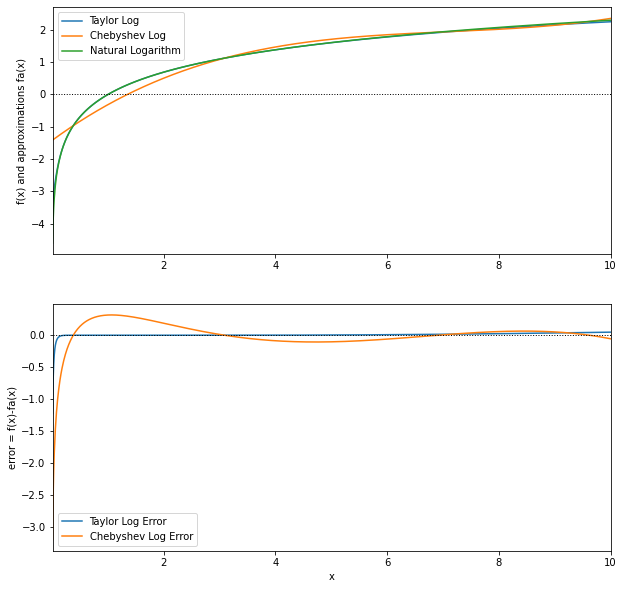

In [7]:
def taylor_ln(x, degree=5):
    result = 0
    for n in range(degree):
        t = (2 * n) + 1
        result += ((1 / t) * (((x - 1)/(x + 1))** t))
    return 2 * result

r = 10
chebyshev_ln =  ChebyshevPolynomial('chebyshev_ln').fit(np.log, 4, 0.0001, r)
showplots(np.log, [taylor_ln, chebyshev_ln], 0.01 ,  r, 
          names=['Natural Logarithm', 'Taylor Log', 'Chebyshev Log'])

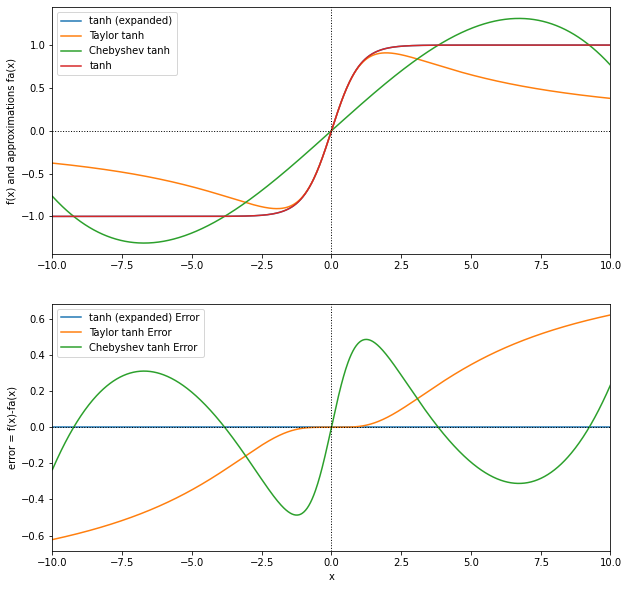

In [8]:
def tanh(x):
    return np.tanh(x)

def tanh_alt(x):
    a = np.exp(x)
    b = np.exp(-x)
    return (a - b) / (a + b)

def taylor_tanh(x, degree= 5):
    a = taylor_exp(x)
    b = taylor_exp(-x)
    return (a - b) / (a + b)

def chebyshev_tanh_exp(x):
    a = chebyshev_exp(x)
    b = chebyshev_exp(-x)
    return (a - b) / (a + b)

r = 10
chebyshev_tanh =  ChebyshevPolynomial('chebyshev_tanh').fit(tanh, 4, -r, r)
showplots(tanh, [tanh_alt, taylor_tanh, chebyshev_tanh], -r ,  r, 
          names=['tanh', 'tanh (expanded)', 'Taylor tanh', 'Chebyshev tanh'])


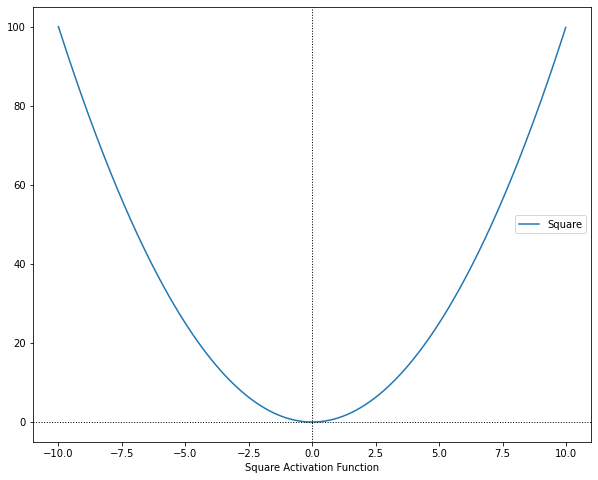

In [9]:
def square_activation(x):
    return x * x

r = 10
X = np.arange(-r, r, 10 ** -2)
Y = [square_activation(x) for x in X]

ys = [(Y, "Square")]
errors = [np.abs(Y - y[0]) for y in ys[1:]]
plot_vs(X, ys, errors, "Square Activation Function")

### ReLU approximation in CryptoDL

In [10]:
import sympy as sp

def integrate_sigmoid():
    x = sp.Symbol('x')
    return sp.integrate(1 / (1 + sp.exp(-x)), x)
integrate_sigmoid()

x + log(1 + exp(-x))

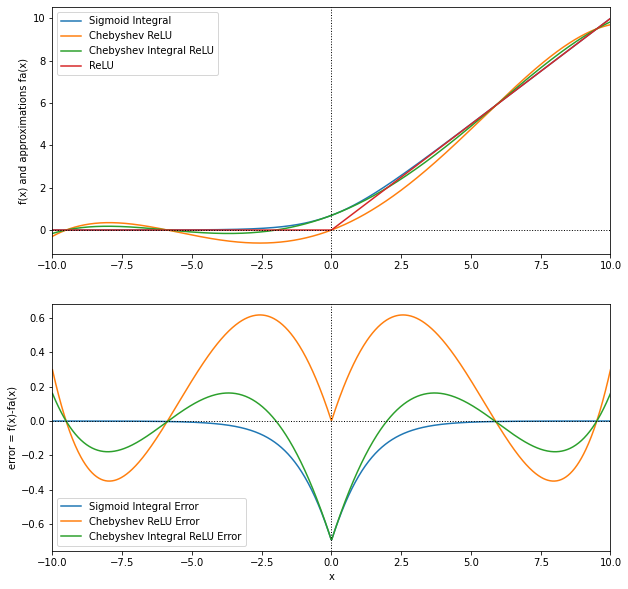

In [23]:
def integral_sigmoid(x):
    return x + np.log(1 + np.exp(-x))

def taylor_integral_sigmoid(x, degree=9):
    return x + taylor_ln(1 + taylor_exp(-x, degree), degree)

r = 10
chebyshev_relu = ChebyshevPolynomial('chebyshev_relu').fit(relu, 5, -r, r)
chebyshev_integral_relu = ChebyshevPolynomial('chebyshev_integral_relu').fit(integral_sigmoid, 5, -r, r)

showplots(relu, [integral_sigmoid, chebyshev_relu, chebyshev_integral_relu], -r ,  r, 
          names=['ReLU', 'Sigmoid Integral', 'Chebyshev ReLU', 'Chebyshev Integral ReLU'])

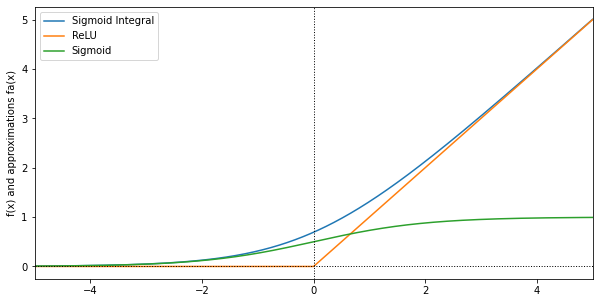

In [22]:
r = 5
showplot(sigmoid, [integral_sigmoid, relu], -r, r, ['Sigmoid', 'Sigmoid Integral', 'ReLU'])

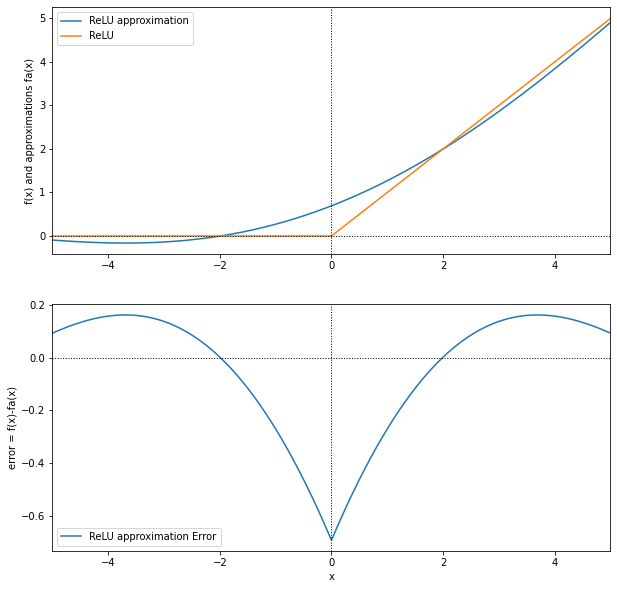

In [13]:
r = 5
showplots(relu, [chebyshev_integral_relu], -r, r, ['ReLU', 'ReLU approximation'])

In [14]:
import sympy as sp

def integrate_tanh():
    x = sp.Symbol('x')
    a = sp.exp(x)
    b = sp.exp(-x)
    return sp.integrate(((a - b)) / ((a + b)), x)

def sp_tanh():
    x = sp.Symbol('x')
    return sp.tanh(x)
sp.diff(sp.integrate(sp_tanh()))
integrate_tanh()

-x + log(exp(2*x) + 1)

In [15]:
def derivative_tanh():
    x = sp.Symbol('x')
    return sp.diff(-x + sp.log(sp.exp(2 * x) + 1), x)
derivative_tanh()

-1 + 2*exp(2*x)/(exp(2*x) + 1)

No handles with labels found to put in legend.


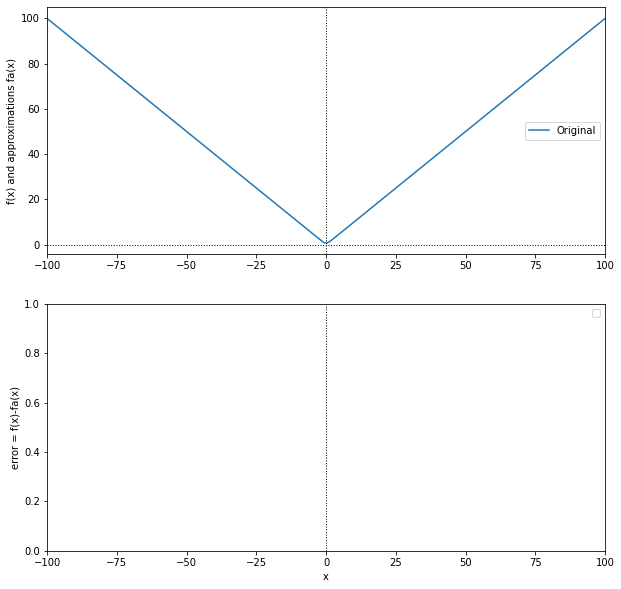

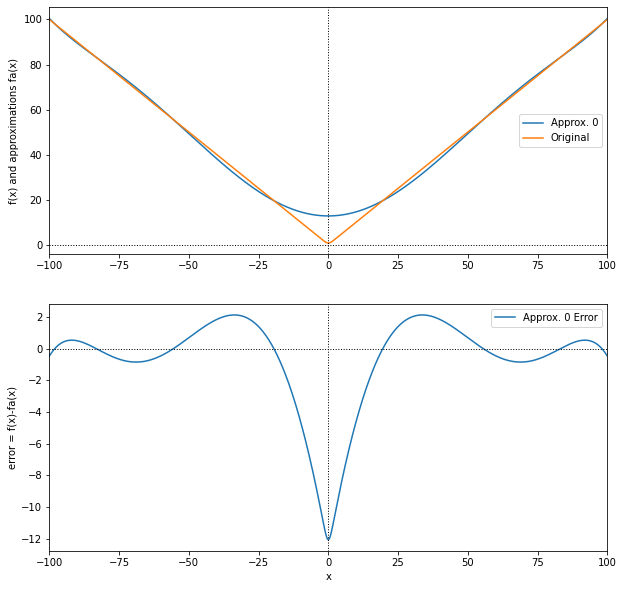

In [16]:
def integral_tanh(x):
    return -x + np.log(np.exp(2 * x) + 1)


def taylor_integral_sigmoid(x, degree=9):
    return x + taylor_ln(1 + taylor_exp(-x, degree), degree)

r = 100
showplots(integral_tanh, [],  -r , r)
chebyshev_tanh = ChebyshevPolynomial().fit(integral_tanh, 8, -r, r)
showplots(integral_tanh, [chebyshev_tanh], -r , r)

Assuming the function has an approximation:

\begin{equation*}
f\left( x \right) = \sum\limits_{n = 0}^\infty {{c_n}{{\left( {x - a} \right)}^n}} = {c_0} + {c_1}\left( {x - a} \right) + {c_2}{\left( {x - a} \right)^2} + {c_3}{\left( {x - a} \right)^3} + {c_4}{\left( {x - a} \right)^4} + \cdots
\end{equation*}

Then we have to calculate the coefficients $c_1$ to $c_n$:

$c_0 = f(a)$

$c_1 = f'(a)$

$c_2 = f''(a)$

$c_n = f^{(n)}(a)$

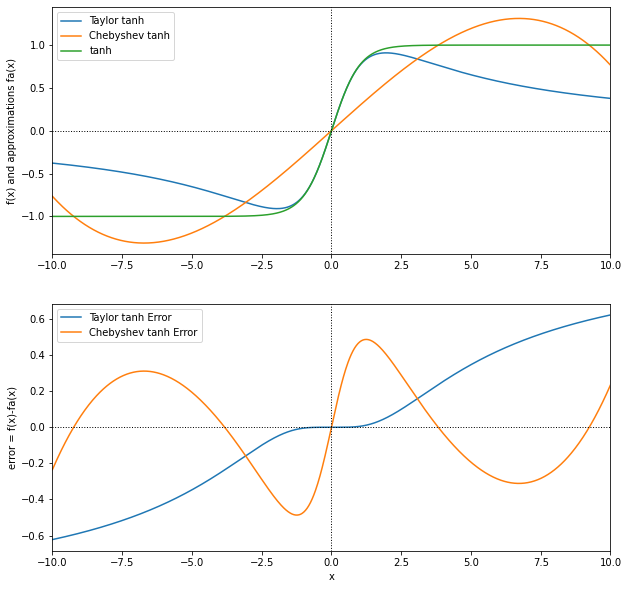

In [18]:
def tanh(x):
    return np.tanh(x)

def tanh_alt(x):
    a = np.exp(x)
    b = np.exp(-x)
    return (a - b) / (a + b)

def taylor_tanh(x, degree= 5):
    a = taylor_exp(x)
    b = taylor_exp(-x)
    return (a - b) / (a + b)

def chebyshev_tanh_exp(x):
    a = chebyshev_exp(x)
    b = chebyshev_exp(-x)
    return (a - b) / (a + b)

r = 10
chebyshev_tanh =  ChebyshevPolynomial('chebyshev_tanh').fit(tanh, 4, -r, r)
showplots(tanh, [taylor_tanh, chebyshev_tanh], -r ,  r, 
          names=['tanh', 'Taylor tanh', 'Chebyshev tanh'])
